Perspective Transform by auto detecting countour

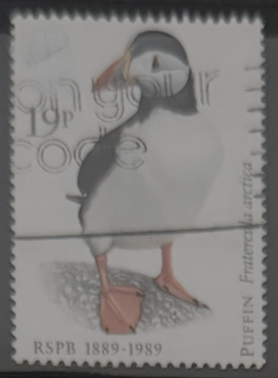

In [17]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 3000

from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

image = Image.open("../data/album/stamp2.png")
display(image.resize((image.width // 2, image.height // 2)))


In [2]:
from typing import List, Tuple

import cv2
import torch
import numpy as np
from PIL import Image
from transformers import AutoModelForMaskGeneration, AutoProcessor


def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the contour
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon to a segmentation mask.

    Args:
    - polygon (list): List of (x, y) coordinates representing the vertices of the polygon.
    - image_shape (tuple): Shape of the image (height, width) for the mask.

    Returns:
    - np.ndarray: Segmentation mask with the polygon filled.
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to an array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask


# def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
#     masks = masks.cpu().float()
#     masks = masks.permute(0, 2, 3, 1)
#     masks = masks.mean(axis=-1)
#     masks = (masks > 0).int()
#     masks = masks.numpy().astype(np.uint8)
#     masks = list(masks)

#     if polygon_refinement:
#         for idx, mask in enumerate(masks):
#             shape = mask.shape
#             polygon = mask_to_polygon(mask)
#             mask = polygon_to_mask(polygon, shape)
#             masks[idx] = mask

#     return masks

def refine_mask(mask: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    mask = mask.cpu().float()
    mask = mask.permute(1, 2, 0)
    mask = mask.mean(axis=-1)
    mask = (mask > 0).int()
    mask = mask.numpy().astype(np.uint8)

    if polygon_refinement:
        shape = mask.shape
        polygon = mask_to_polygon(mask)
        mask = polygon_to_mask(polygon, shape)

    return mask


def segment(image: Image.Image, polygon_refinement: bool = False) -> np.ndarray:
    """
    Use Segment Anything (SAM) to generate masks given an image + a set of bounding boxes.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = "facebook/sam-vit-base"
    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    inputs = processor(images=image, return_tensors="pt").to(device)

    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )

    mask = refine_mask(masks[0][0], polygon_refinement)

    return mask


In [3]:
mask = segment(image=image, polygon_refinement=True)
print(mask.shape)


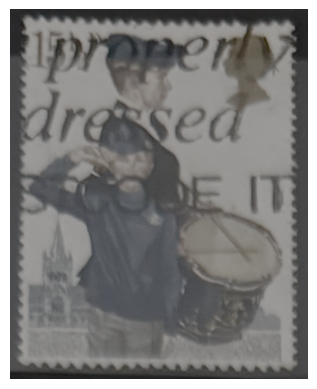

In [19]:

def annotate(image: Image.Image, mask: np.ndarray) -> np.ndarray:
    # Convert PIL Image to OpenCV format
    image_cv2 = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    color = np.random.randint(0, 256, size=3)

    # Convert mask to uint8
    # mask_uint8 = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(image: Image.Image, mask: np.ndarray) -> None:
    annotated_image = annotate(image, mask)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

plot_detections(image, mask)


In [ ]:
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
